In [1]:
import numpy as np
from math import factorial
import matplotlib.pyplot as plt
from matplotlib import animation
from numpy.linalg import norm

import analytical_solution as anso
import functions as fu
import animation_func as anim

## Eigenstates of the Harmonic oscillator

$$
|\psi_n(x)\rangle = \frac{1}{\pi 2^nn!} e^{-\frac{(x-x_0)^2}{2}} H_n\left(x-x_0 \right)
$$

where $H_n\left(x \right)$ are the Hermite polynomials of order $n$

NOTE: These are the eigenstates of the following Hamiltonian

$$
H=\frac{p^{2}}{2}+ \frac{1}{2}(x-x_{0})^{2}
$$

Any translation of $|\psi_n(x)\rangle \longrightarrow |\psi_n(x+\delta x)\rangle$ results in a state which is NO MORE an eigenstate of the original Hamiltonian.
We could then decompose $|\psi_n(x+\delta x)\rangle = \sum_{m}C_{m}|\psi_n(x)\rangle$ from some coefficients $C_{m}$ associated to the old eigenstates.

## Initialization for the simulation

Initialize correctly the real space and the momentum grid.
Be careful about the initialization of the momentum, how it should be treated.
Have a look at the `np.fft.fft` documentation.

<details>
  <summary>Solution part 1</summary>

```python
self.x = np.arange(-xmax + xmax / num_x, xmax, self.dx)
...
self.k = np.concatenate((np.arange(0, num_x / 2),
                                 np.arange(-num_x / 2, 0))) * self.dk
```
</details>

## Set the evolution operators for the imaginary time

Set the coefficiant `coeff` such that it enables real or
imaginary time evolution

<details>
  <summary>Solution part 2</summary>

```python
1 if par.im_time else 1j
```
</details>

## Time evolution

Complete the split operator method filling the part for imaginary time evolution.
The wavefunction should be normalized at any time!

<details>
  <summary>Solution part 3</summary>

```python
renorm_factor = np.sum( density * par.dx )
opr.wfc /= np.sqrt(renorm_factor)
```
</details>

## Code 

In [3]:
N = 1000    # Number of intervals between -L and L
L = 10
dt = 0.00025
t_steps = 2000
omega = 1

params = fu.Param(xmax=L, num_x=N, dt=dt, timesteps=t_steps, im_time=True)


# WAVE FUNCTION INITIALIZATION

custom_wfc = np.zeros(N, dtype=complex)

# I initialize the wavefunction to the ground state (n=0)
# And centered in 0
wfcoffset=0     # W.f. offset --> it's x - x_0
n=0             # Order of the Hermite Polynomial --> correspond to the ground state

custom_wfc += anso.stationary_state(params.x , omega, n=1).astype(complex)

# I perform the initialization and the time evolution
res, opr, pot_evol = fu.init_and_splitop(params, omega, custom_wfc)

In [4]:
print(f"The final energy of your systems is: {fu.calculate_energy(params, opr)}")


The final energy of your systems is: 1.3390392856724458


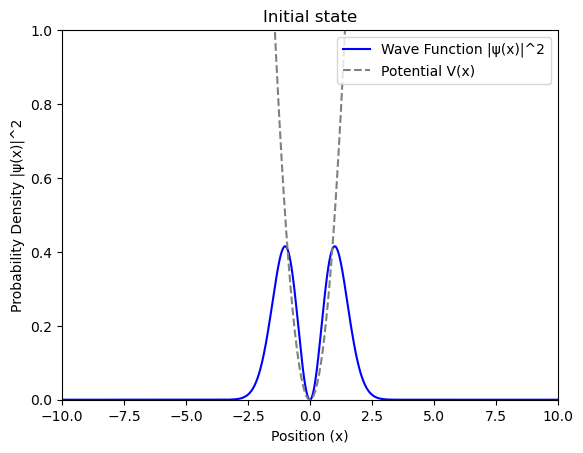

In [5]:
fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(0, 1)
ax.set_xlabel("Position (x)")
ax.set_ylabel("Probability Density |ψ(x)|^2")
ax.set_title("Initial state")
ax.plot(params.x, res[0, 0, :], label="Wave Function |ψ(x)|^2", color='blue')
ax.plot(params.x, pot_evol[0, 0, :], label="Potential V(x)", color='gray', linestyle='--')
ax.legend(loc="upper right")

plt.show()


range(0, 2000, 20)


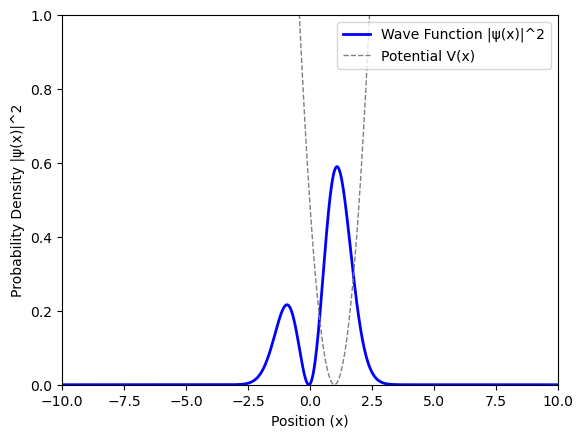

In [6]:
anim.plot_git(params, res, pot_evol)